In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd

## Visualización y preparación de los datos

In [14]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_valid = X_train_full[:5000]/255
y_valid = y_train_full[:5000]
X_train = X_train_full[5000:]/255
y_train = y_train_full[5000:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


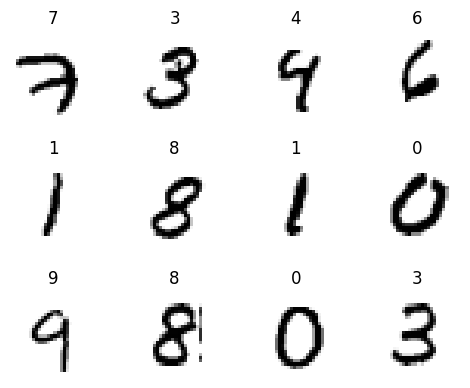

In [3]:
n_rows = 3
n_cols = 4
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Entrenamiento



Para realizar el entrenamiento, he diseñado una función que realiza una exploración por una serie de hiperparámetros. Concretamente, para poder reslver lo planteado en el enunciado de la práctica, se va a entrenar un modelo para cada combinación de hiperparámetros. Estos son:
```python
hiperparametros = {
    'optimizer': ['sgd', 'adam', 'rmsprop'],
    'multiply_factor': [1, 2],
    'learning_rate': [0.003, 0.03, 0.3],
    'n_hidden_layers': [3, 4]
}
```

Es decir, se entrenará un perceptrón con 3 capas ocultas, además de un perceptrón con 4. Para cada caso, se podrabará un número distinto de neuronas, usando una arquitectura piramidal. Para realziar esto, se utiliza el factor de multiplicación `multiply_factor`. Por ejemplo, se entrenará una red de 4 capas ocultas con `256`, `128`, `64` y `32` neuronas por cada capa y otra red con `2*256`, `2*128`, `2*64` y `2*32`.


Además de esto, se probarán diferentes razones de aprendizaje, como `0.003`, `0.03`, y `0.3`.


Por otro lado, para aumentar la experimentación, se realizará entrenamiento con optmizadores como `SGD`, `Adam` y `RMSProp`


Como método de regularización se introduce `Early Stopping` como callback.

In [12]:
def create_model(n_hidden_layers: list = 3, multiply_factor: int = None) -> tf.keras.Sequential:
    """Create a model with n_hidden_layers hidden layers and multiply_factor neurons

    Parameters
    ----------
    n_hidden_layers : list, optional
        Number of hidden layers, by default 3
    multiply_factor : int, optional
        Multiply factor to increase the number of neurons, by default None

    Returns
    -------
    tf.keras.Sequiential
        A keras model

    Raises
    ------
    ValueError
        If n_hidden_layers is not 3 or 4
    """
    if n_hidden_layers not in [3, 4]:
        raise ValueError("n_hidden_layers must be 3 or 4")

    n_neurons = [2**exp for exp in np.arange(5, 9)[::-1][-n_hidden_layers:]]

    if multiply_factor:
        n_neurons = [neu*multiply_factor for neu in n_neurons]

    input_layer = [tf.keras.Input(shape=(28, 28)), tf.keras.layers.Flatten()]
    hidden_layers = [tf.keras.layers.Dense(n_neurons[hl], activation='relu') for hl in range(n_hidden_layers)]
    output_layer = [tf.keras.layers.Dense(10, activation='softmax')]
    model = tf.keras.Sequential(input_layer+hidden_layers+output_layer)

    return model

In [19]:
def explore_models(
    hyperparameters: dict[str, list],
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray
    ) -> dict[str, list]:
    """Explore different models with different hyperparameters

    Parameters
    ----------
    hyperparameters : dict[str, list]
        Hyperparameters to explore
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_valid : np.ndarray
        Validation features
    y_valid : np.ndarray
        Validation labels

    Returns
    -------
    _type_
        Performance of the models
    """    """"""
    all_combinations = list(itertools.product(*hyperparameters.values()))
    models_performance = {}
    for params in all_combinations:
        print(f"""Training model with parameters:
        optimizer = {params[0]},
        multiply factor = {params[1]},
        learning_rate = {params[2]},
        n hidden layers = {params[3]}\n""")
        model = create_model(n_hidden_layers=params[3], multiply_factor=params[1])
        model.compile(loss='sparse_categorical_crossentropy', optimizer=params[0], metrics=['accuracy'])

        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])
        models_performance[str(params)] = history.history
        models_performance[str(params)]['test_loss'] = model.evaluate(X_test, y_test)[0]
        models_performance[str(params)]['test_accuracy'] = model.evaluate(X_test, y_test)[1]

    return models_performance

In [6]:
hiperparametros = {
    'optimizer': ['sgd', 'adam', 'rmsprop'],
    'multiply_factor': [1, 2],
    'learning_rate': [0.003, 0.03, 0.3],
    'n_hidden_layers': [3, 4]
}

In [19]:
models_performance = explore_models(hyperparameters=hiperparametros, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)

Training model with parameters: 
    optimizer = sgd, 
    multiply factor = 1, 
    learning_rate = 0.003,
    n hidden layers = 3

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6535 - loss: 1.1831 - val_accuracy: 0.9120 - val_loss: 0.3172
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9143 - loss: 0.3031 - val_accuracy: 0.9360 - val_loss: 0.2328
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9330 - loss: 0.2329 - val_accuracy: 0.9484 - val_loss: 0.1847
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9455 - loss: 0.1867 - val_accuracy: 0.9556 - val_loss: 0.1609
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9542 - loss: 0.1567 - val_accuracy: 0.9610 - val_loss: 0.1407
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9608 - loss: 0.1369 - val_accuracy: 0.9626 - val_loss: 0.1303
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9654 - loss:

Dado que realizar el entrenamiento de todos los modelos puede implicar un tiempo considerable, se guardan los resultados de las métricas en un `json` para poder hacer uso en un futuro

In [20]:
filepath = "/content/drive/MyDrive/Master en Investigación IA/Deep Learning/PEC0/models_performance.json"

with open(filepath, 'w') as f:
    json.dump(models_performance, f)

 ## Exploración de modelos

Para realizar la exploración de manera informada se utilizará la métrica de `Accuracy` sobre el conjunto Test. Para ello se ha creado además una función que se encarga de construir el *plot* que dibuja la función de pérdida sobre el conjunto de entrenamiento y validación.

In [33]:
def plot_loss_curves(model_performance: dict[str, list], model_name: str):
    """Plot the loss curves of the models

    Parameters
    ----------
    model_performance : dict[str, list]
        Performance of the models
    model_name : str
        Name of the model
    """
    sns.set(style="whitegrid", palette="pastel")
    sns.lineplot(x=range(len(model_performance['val_loss'])), y=model_performance['val_loss'], linewidth=2, color='#37AFE1', label='Validation')
    sns.lineplot(x=range(len(model_performance['loss'])), y=model_performance['loss'], linewidth=2, color='#FF5733', label='Training')
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title(model_name)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

In [28]:
with open("/content/drive/MyDrive/Master en Investigación IA/Deep Learning/PEC0/models_performance.json", 'r') as f:
  models_performance = json.load(f)

In [24]:
models_performance["('sgd', 1, 0.003, 3)"].keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'test_loss', 'test_accuracy'])

In [25]:
# Definition of useful metrics to compare between models
comparative_table_dict = {
    'model': [],
    'test_loss': [],
    'test_accuracy': []
}

# Build dictionary for the pd.DataFrame
for k, v in models_performance.items():
  comparative_table_dict['model'].append(k)
  comparative_table_dict['test_loss'].append(v['test_loss'])
  comparative_table_dict['test_accuracy'].append(v['test_accuracy'])

# pd.DataFrame with the performance sorted from higher to lower accuracy
comparative_table = pd.DataFrame(comparative_table_dict).sort_values(by='test_accuracy', ascending=False)

A continuación se muestran los modelos con un `Test Accuracy` superior a `0.98`, ordenados de mayor a menor por esta misma métrica.

In [6]:
# Select models with Accuracy higher to 0.98
mask_over_98 = comparative_table['test_accuracy'] > 0.98
over_98_accuracy = comparative_table[mask_over_98]
over_98_accuracy

,model,test_loss,test_accuracy
35,"('rmsprop', 2, 0.3, 4)",23.712189,0.9823
15,"('adam', 1, 0.03, 4)",19.955053,0.9809
21,"('adam', 2, 0.03, 4)",19.892550,0.9809
34,"('rmsprop', 2, 0.3, 3)",25.522415,0.9808
13,"('adam', 1, 0.003, 4)",15.056271,0.9803


Se puede observar que el modelo con un valor más alto de `Test Accuracy` posee uno de los valores más altos de `Test Loss` de entre los 5 mostrados (por encima de `0.98` en `Test Accuracy`).

Viendo esto, los modelos con 4 capas ocultas, en vez de 5, poseen mejores métricas. Los optimizadores `RMSProp` y `Adam` ofrecen mejores resultados en términos de `Accuracy` sobre Test que el *Descenso del Gradiente Estocástico* (`SGD`)

Otra manera de visualizar el desempeño de estos modelos en función del `Accuracy` sobre el conjunto test es con el siguiente gráfico de barras

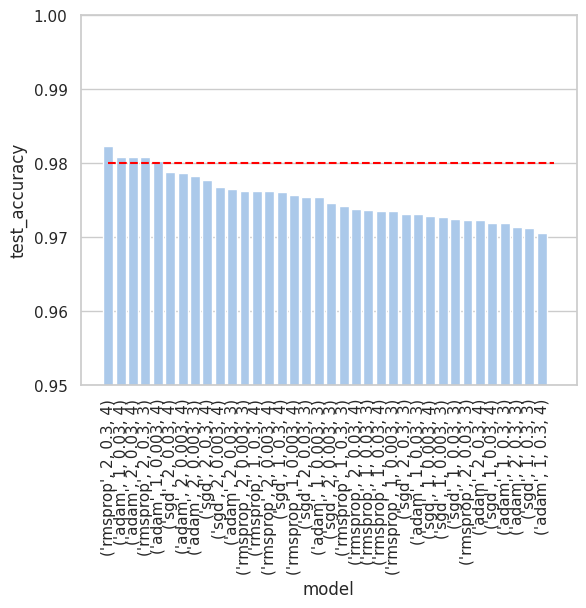

In [11]:
sns.set(style="whitegrid", palette="pastel")
sns.barplot(x='model', y='test_accuracy', data=comparative_table)
plt.xticks(rotation=90)
plt.ylim(0.95, 1)
plt.hlines(y=0.98, xmin=0, xmax=len(comparative_table), linestyle='--', color='red')
plt.show()

## Visualización curvas Training-Validation para los mejores modelos (3 y 4 capas ocultas)

Se decide mostrar la función de pérdida a lo largo de las *epochs* de entrenamiento para los 5 modelos con `Test Accuracy` por encima de `0.98`

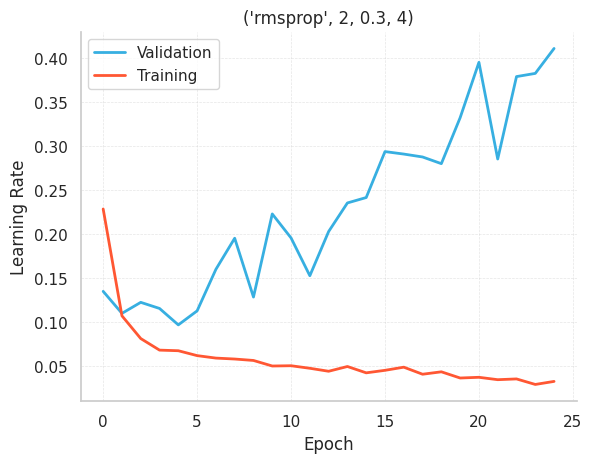

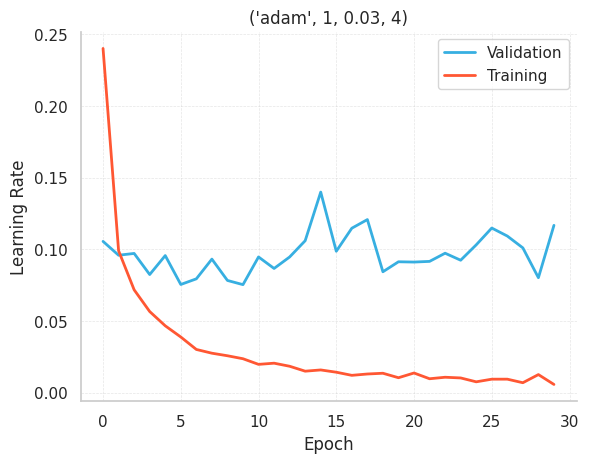

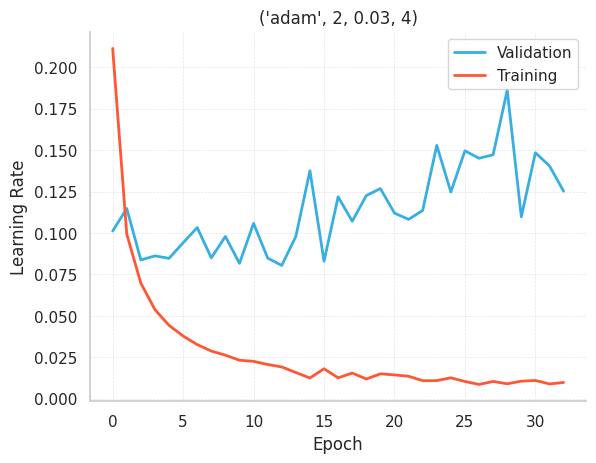

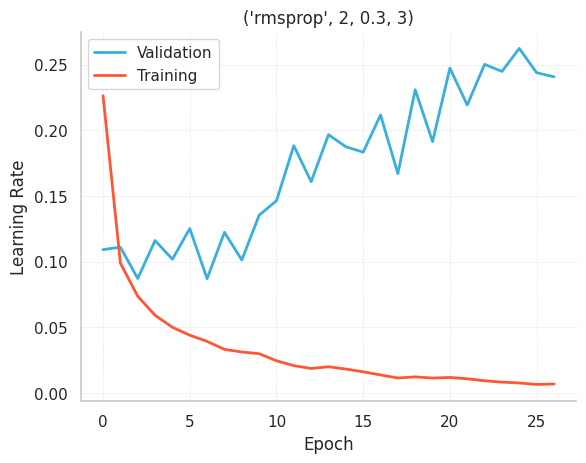

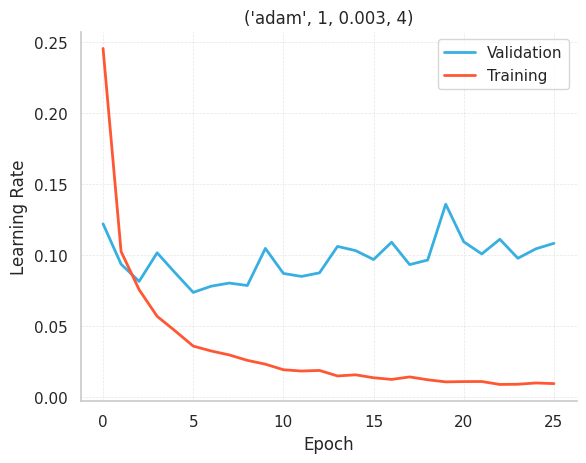

In [34]:
for model in over_98_accuracy.model:
  plot_loss_curves(models_performance[model], model_name=model)

Viendo estas gráficas de las curvas de pérdida, se observa un crecimiento del error de validación a medida que avanzan las épocas, esto puede indicar un overfitting (sobreaprendizaje) de los datos de entremaiento.

Gracias al uso del callback de `early stopping`, el entrenamiento se para cuando este error de validación va en aumento, mientras que el error de entrenamiento tiene a bajar de manera asintótica.

Para poder realizar una experimentación más variada, seríe interesante añadir `Batch Gradient Descend` o `Mini-Batch Gradient Descend`, aunque las oscilaciones en el aprendizaje para el conjunto `MNIST` no son tan significativas.

Otro aspecto a probar puede ser la aplicación de regularización, para evitar el sobreaprendizaje, por ejemplo usando `L2`, `L1` o `dropout`